In [1]:
%matplotlib inline
import numpy
import pandas
import matplotlib.pyplot as plt

import os, sys
sys.path.append('../code')

# Generate events

In [116]:
from utils import straight_tracks_generator
events = straight_tracks_generator(n_events=1000, n_tracks=2, n_noise=10, sigma=0.5)

# Tracks Recognition

In [117]:
event = events[events.EventID == 0]
X = event.X.values.reshape(-1,1)
y = event.y.values

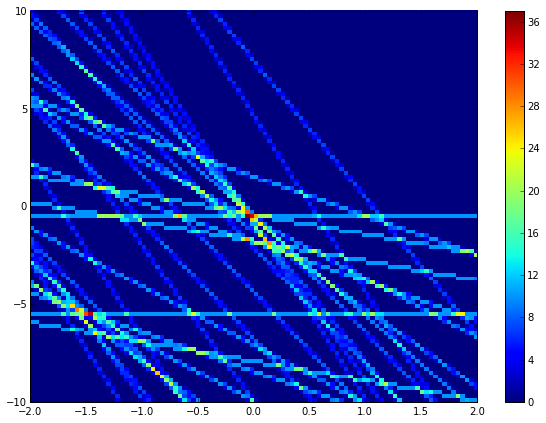

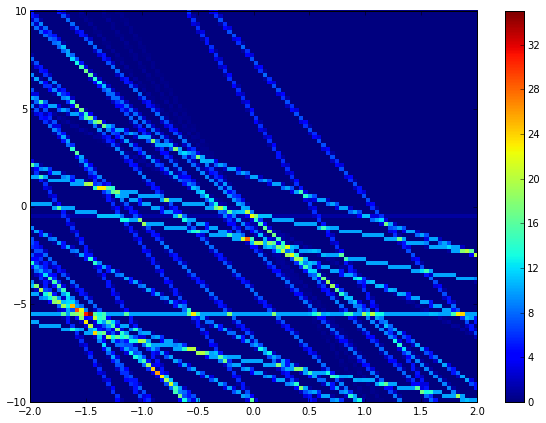

In [121]:
from hough import HoughLinear

hl = HoughLinear(k_params=(-2, 2, 100), b_params=(-10, 10, 100), n_candidates=2, show=True)
labels, candidates = hl.fit(X, y, weights_mul=10)
labels = labels - 1

# Plot True and Recognized Tracks

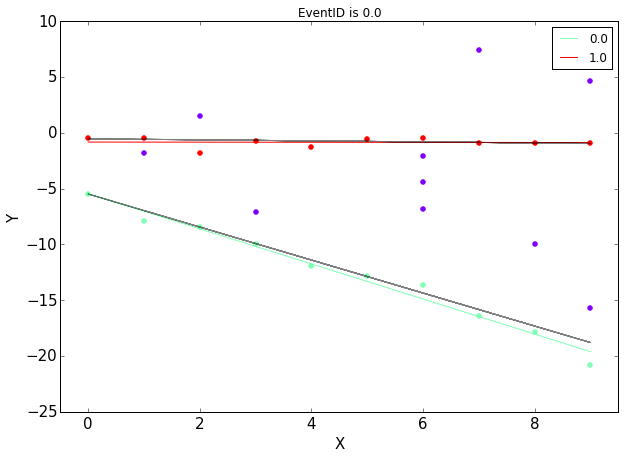

In [122]:
from utils import plot_straight_tracks
plot_straight_tracks(event, labels)
plt.xlim(-0.5, 9.5)
plt.ylabel('Y', size=15)
plt.xlabel('X', size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

## All Metrics for All events

In [65]:
from metrics import ParameterMatchingEfficiency, HitsMatchingEfficiency

results = pandas.DataFrame(columns=['EventID', 'HmAvgEff',
                                    'HmRecoEff', 'HmGhostRate', 'HmCloneRate', 
                                    'PmRecoEff', 'PmGhostRate', 'PmCloneRate'])

for event_id in numpy.unique(events.EventID.values):
    
    event = events[events.EventID == event_id]
    X = event.X.values.reshape(-1,1)
    y = event.y.values
    
    hl = HoughLinear(k_params=(-2, 2, 10), b_params=(-10, 10, 10), n_candidates=2, show=False)
    labels, candidates = hl.fit(X, y, weights_mul=10)
    labels = labels - 1
    
    hme = HitsMatchingEfficiency()
    hme.fit(event, labels)
    
    pme = ParameterMatchingEfficiency(delta_k = 0.4, delta_b=2.)
    pme.fit(event, labels)
    
    results.loc[len(results)] = [event_id, hme.avg_efficiency_, 
                                 hme.recognition_efficiency_, hme.ghost_rate_, hme.clone_rate_, 
                                 pme.recognition_efficiency_, pme.ghost_rate_, pme.clone_rate_]

In [66]:
results.mean(axis=0)

EventID        499.500000
HmAvgEff         0.842829
HmRecoEff        0.979000
HmGhostRate      0.017500
HmCloneRate      0.000000
PmRecoEff        0.966500
PmGhostRate      0.031000
PmCloneRate      0.002500
dtype: float64

# Experiments

In [72]:
def get_metrics(n_events, n_tracks):
    
    events = straight_tracks_generator(n_events=n_events, n_tracks=n_tracks, n_noise=20, sigma=0.5)
    
    results = pandas.DataFrame(columns=['EventID', 'HmAvgEff',
                                        'HmRecoEff', 'HmGhostRate', 'HmCloneRate', 
                                        'PmRecoEff', 'PmGhostRate', 'PmCloneRate'])

    for event_id in numpy.unique(events.EventID.values):

        event = events[events.EventID == event_id]
        X = event.X.values.reshape(-1,1)
        y = event.y.values

        hl = HoughLinear(k_params=(-2, 2, 25), b_params=(-10, 10, 25), n_candidates=n_tracks, show=False)
        labels, candidates = hl.fit(X, y, weights_mul=10)
        labels = labels - 1

        hme = HitsMatchingEfficiency()
        hme.fit(event, labels)

        pme = ParameterMatchingEfficiency(delta_k = 0.2, delta_b=1.0)
        pme.fit(event, labels)

        results.loc[len(results)] = [event_id, hme.avg_efficiency_, 
                                     hme.recognition_efficiency_, hme.ghost_rate_, hme.clone_rate_, 
                                     pme.recognition_efficiency_, pme.ghost_rate_, pme.clone_rate_]
        
    metrics = results[['HmRecoEff', 'HmGhostRate', 'HmCloneRate', 
                       'PmRecoEff', 'PmGhostRate', 'PmCloneRate']].values.mean(axis=0)
    
    return metrics

def get_metrics_dependencies(n_events, n_tracks):
    
    results = pandas.DataFrame(columns=['HmRecoEff', 'HmGhostRate', 'HmCloneRate', 
                                        'PmRecoEff', 'PmGhostRate', 'PmCloneRate'])
    
    for i in n_tracks:
        
        results.loc[len(results)] = get_metrics(n_events, i)
        
    return results

In [95]:
n_tracks = [1, 2, 3, 4, 5, 7, 10, 12, 15, 20]#, 25, 30, 40, 50, 60, 70, 80, 90, 100]
results2 = get_metrics_dependencies(1000, n_tracks)
results2.head()

,HmRecoEff,HmGhostRate,HmCloneRate,PmRecoEff,PmGhostRate,PmCloneRate
0,0.973000,0.0240,0.000000,0.8980,0.102000,0.000000
1,0.955500,0.0375,0.001500,0.8745,0.123500,0.002000
2,0.932333,0.0610,0.003667,0.8540,0.139333,0.006667
3,0.892500,0.0970,0.007250,0.8125,0.177000,0.010500
4,0.864200,0.1266,0.007000,0.7948,0.198400,0.006800


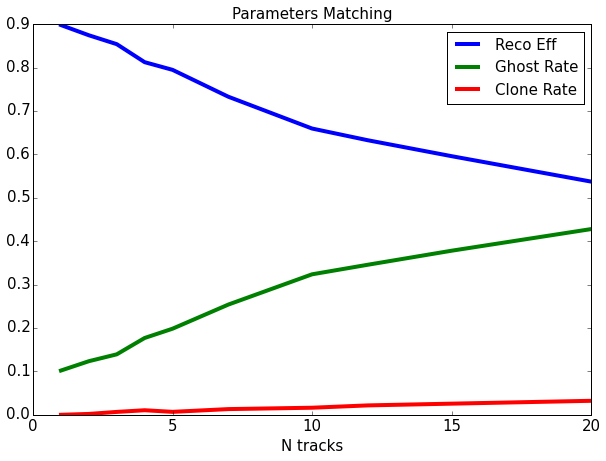

In [96]:
plt.figure(figsize=(10, 7))
plt.plot(n_tracks, results2['PmRecoEff'].values, linewidth=4, label='Reco Eff')
plt.plot(n_tracks, results2['PmGhostRate'].values, linewidth=4, label='Ghost Rate')
plt.plot(n_tracks, results2['PmCloneRate'].values, linewidth=4, label='Clone Rate')
plt.legend(loc='best', prop={'size':15})
plt.xlabel('N tracks', size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.title('Parameters Matching', size=15)
plt.show()

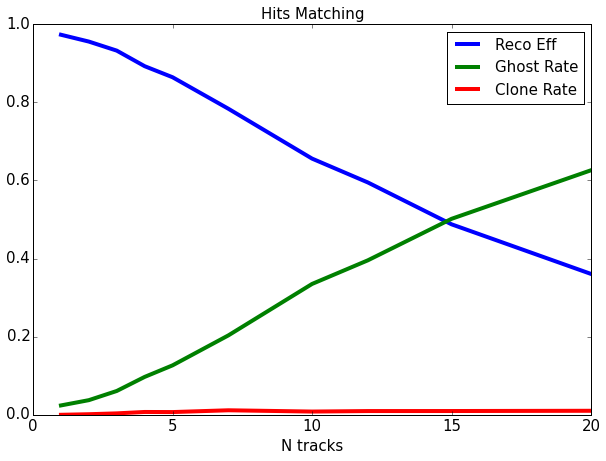

In [97]:
plt.figure(figsize=(10, 7))
plt.plot(n_tracks, results2['HmRecoEff'].values, linewidth=4, label='Reco Eff')
plt.plot(n_tracks, results2['HmGhostRate'].values, linewidth=4, label='Ghost Rate')
plt.plot(n_tracks, results2['HmCloneRate'].values, linewidth=4, label='Clone Rate')
plt.legend(loc='best', prop={'size':15})
plt.xlabel('N tracks', size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.title('Hits Matching', size=15)
plt.show()

# Simple Template Matching as Baseline

In [98]:
from TemplateMatching import SimpleTemplateMatching
def get_metrics_baseline(n_events, n_tracks):
    
    events = straight_tracks_generator(n_events=n_events, n_tracks=n_tracks, n_noise=20, sigma=0.5)
    
    results = pandas.DataFrame(columns=['EventID', 'HmAvgEff',
                                        'HmRecoEff', 'HmGhostRate', 'HmCloneRate', 
                                        'PmRecoEff', 'PmGhostRate', 'PmCloneRate'])

    for event_id in numpy.unique(events.EventID.values):

        event = events[events.EventID == event_id]
        X = event.X.values.reshape(-1,1)
        y = event.y.values

        stm = SimpleTemplateMatching(8, 1.)
        stm.fit(X, y)
        labels = stm.labels_

        hme = HitsMatchingEfficiency()
        hme.fit(event, labels)

        pme = ParameterMatchingEfficiency(delta_k = 0.2, delta_b=1.0)
        pme.fit(event, labels)

        results.loc[len(results)] = [event_id, hme.avg_efficiency_, 
                                     hme.recognition_efficiency_, hme.ghost_rate_, hme.clone_rate_, 
                                     pme.recognition_efficiency_, pme.ghost_rate_, pme.clone_rate_]
        
    metrics = results[['HmRecoEff', 'HmGhostRate', 'HmCloneRate', 
                       'PmRecoEff', 'PmGhostRate', 'PmCloneRate']].values.mean(axis=0)
    
    return metrics

def get_metrics_dependencies_baseline(n_events, n_tracks):
    
    results = pandas.DataFrame(columns=['HmRecoEff', 'HmGhostRate', 'HmCloneRate', 
                                        'PmRecoEff', 'PmGhostRate', 'PmCloneRate'])
    
    for i in n_tracks:
        
        results.loc[len(results)] = get_metrics_baseline(n_events, i)
        
    return results

In [99]:
results3 = get_metrics_dependencies_baseline(1000, n_tracks)
results3.head()

,HmRecoEff,HmGhostRate,HmCloneRate,PmRecoEff,PmGhostRate,PmCloneRate
0,0.997000,0.021000,0.009000,0.929000,0.114000,0.001000
1,0.960500,0.047000,0.023500,0.872500,0.159500,0.001500
2,0.899333,0.117667,0.032667,0.790667,0.254667,0.006667
3,0.840000,0.171500,0.025750,0.717000,0.315250,0.005750
4,0.764600,0.250800,0.023200,0.666800,0.365800,0.006200


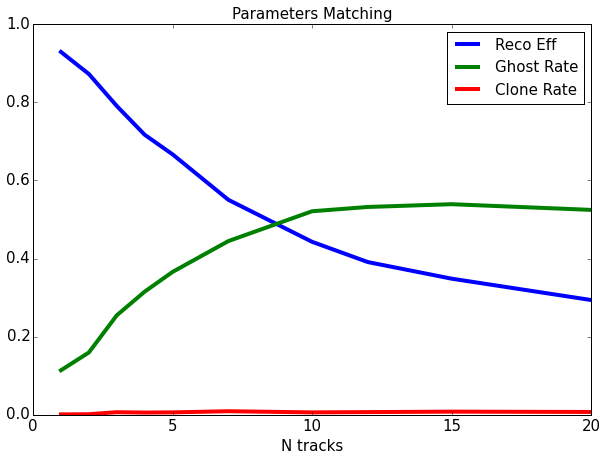

In [100]:
plt.figure(figsize=(10, 7))
plt.plot(n_tracks, results3['PmRecoEff'].values, linewidth=4, label='Reco Eff')
plt.plot(n_tracks, results3['PmGhostRate'].values, linewidth=4, label='Ghost Rate')
plt.plot(n_tracks, results3['PmCloneRate'].values, linewidth=4, label='Clone Rate')
plt.legend(loc='best', prop={'size':15})
plt.xlabel('N tracks', size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.title('Parameters Matching', size=15)
plt.show()

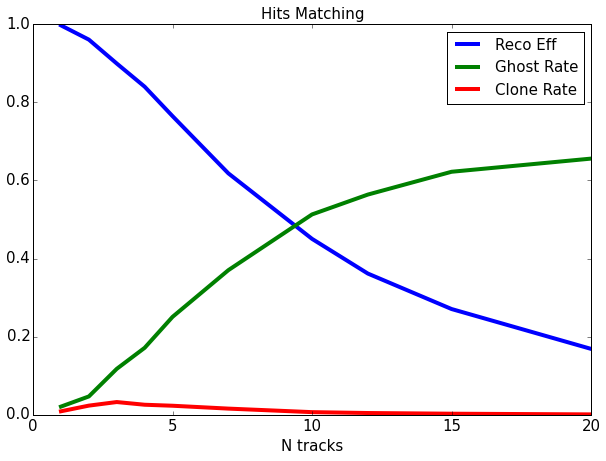

In [101]:
plt.figure(figsize=(10, 7))
plt.plot(n_tracks, results3['HmRecoEff'].values, linewidth=4, label='Reco Eff')
plt.plot(n_tracks, results3['HmGhostRate'].values, linewidth=4, label='Ghost Rate')
plt.plot(n_tracks, results3['HmCloneRate'].values, linewidth=4, label='Clone Rate')
plt.legend(loc='best', prop={'size':15})
plt.xlabel('N tracks', size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.title('Hits Matching', size=15)
plt.show()

# Hough and Simple Template Matching

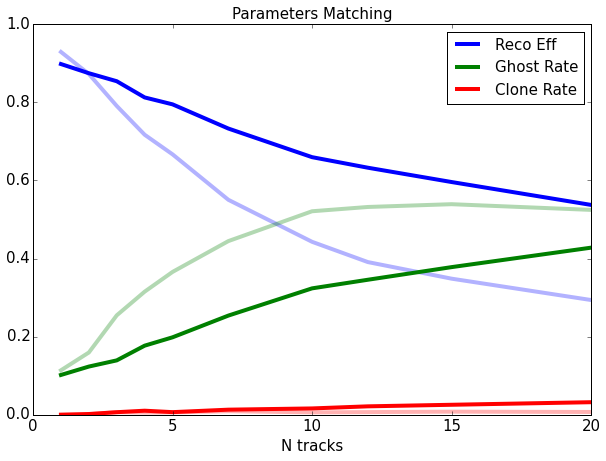

In [102]:
plt.figure(figsize=(10, 7))
plt.plot(n_tracks, results3['PmRecoEff'].values, linewidth=4, alpha=0.3, color='b')
plt.plot(n_tracks, results3['PmGhostRate'].values, linewidth=4, alpha=0.3, color='g')
plt.plot(n_tracks, results3['PmCloneRate'].values, linewidth=4, alpha=0.3, color='r')
plt.plot(n_tracks, results2['PmRecoEff'].values, linewidth=4, label='Reco Eff', color='b')
plt.plot(n_tracks, results2['PmGhostRate'].values, linewidth=4, label='Ghost Rate', color='g')
plt.plot(n_tracks, results2['PmCloneRate'].values, linewidth=4, label='Clone Rate', color='r')
plt.legend(loc='best', prop={'size':15})
plt.xlabel('N tracks', size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.title('Parameters Matching', size=15)
plt.show()

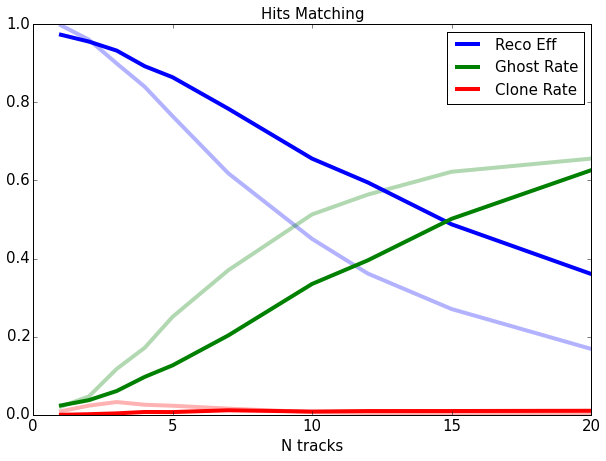

In [103]:
plt.figure(figsize=(10, 7))
plt.plot(n_tracks, results3['HmRecoEff'].values, linewidth=4, alpha=0.3, color='b')
plt.plot(n_tracks, results3['HmGhostRate'].values, linewidth=4, alpha=0.3, color='g')
plt.plot(n_tracks, results3['HmCloneRate'].values, linewidth=4, alpha=0.3, color='r')
plt.plot(n_tracks, results2['HmRecoEff'].values, linewidth=4, label='Reco Eff', color='b')
plt.plot(n_tracks, results2['HmGhostRate'].values, linewidth=4, label='Ghost Rate', color='g')
plt.plot(n_tracks, results2['HmCloneRate'].values, linewidth=4, label='Clone Rate', color='r')
plt.legend(loc='best', prop={'size':15})
plt.xlabel('N tracks', size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.title('Hits Matching', size=15)
plt.show()